In [1]:
import os
import warnings
import pandas as pd
import anndata as ad
import seaborn as sns
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn.preprocessing import minmax_scale

warnings.filterwarnings('ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
%config InlineBackend.figure_format = 'retina'

In [2]:
# Set common path and parameters
main_path = '/data/qiyu/spatialRegion/'
fig_path = main_path + 'figures/SVG/'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'DejaVu Sans'
path = main_path + "benchmark/results/"
slideseq_data = main_path + 'benchmark/Public_data/Brain_Slideseq/'
model = ["Glimmer", "GraphST", "SPIN", "SpaceFlow", "SCANIT", "Banksy"]
data_names = ["01", "02", "03", "04", "05"]
data_type = 'slide_seq'
seed = [1, 2, 3, 4, 5]
load_embedding = False

### 1. Load embedding from Slideseq runs

In [3]:
def select_cells_within_radius(adata, initial_radius=800, min_cells=30000, max_cells=40000, step_size=50):
    spatial_coords = adata.obsm["spatial"]
    center = spatial_coords.mean(axis=0)
    distances = np.sqrt(((spatial_coords - center) ** 2).sum(axis=1))
    radius = initial_radius
    
    while True:
        print(f"Trying radius {radius}.")
        selected_cells = np.where(distances <= radius)[0]
        if len(selected_cells) >= min_cells and len(selected_cells) <= max_cells:
            break
        elif len(selected_cells) < min_cells:
            radius += step_size
        else:
            radius -= step_size
            if radius < 0:
                raise ValueError("Cannot find a suitable radius.")
    print(f"Selected {len(selected_cells)} cells within radius {radius}.")

    return adata[selected_cells].copy()

def load_puck_data(num, path):
    slideseq_path = path
    if os.path.exists(slideseq_path+f"Subset_Puck_Num_{num}.h5ad"):
        adata = sc.read_h5ad(slideseq_path+f"Subset_Puck_Num_{num}.h5ad")

        return adata
    else:
        adata = sc.read_h5ad(slideseq_path+f"Puck_Num_{num}.h5ad")
        adata = adata[adata.obs['DeepCCF'] != 'NA']
        adata.obs["ground_truth"] = adata.obs['DeepCCF'].values
        adata.obsm["spatial"] = adata.obs[['Raw_Slideseq_X', 'Raw_Slideseq_Y']].values

        if '_index' in adata.var.columns:
            adata.var.drop('_index', axis=1, inplace=True)
        if adata.raw is not None and '_index' in adata.raw.var.columns:
            adata.raw.var.drop('_index', axis=1, inplace=True)

        adata = select_cells_within_radius(adata)
        adata.write_h5ad(slideseq_path+f"Subset_Puck_Num_{num}.h5ad")

        return adata

In [4]:
if load_embedding:
    for data in data_names:
        save_file = f"{path}/{data_type}/{data}/all_res.h5ad"
        
        if os.path.exists(save_file):
            adata = ad.read(save_file)
        else:
            adata = load_puck_data(data, slideseq_data)
        
        file_list = []
        for m in model:
            dir_path = os.path.join(path, data_type, data, m)
            if os.path.exists(dir_path):
                file_list.extend([
                    os.path.join(dir_path, f)
                    for f in os.listdir(dir_path)
                    if not f.endswith("run_times.txt")
                ])

        for item in file_list:
            emb_name, _ = os.path.splitext(os.path.basename(item))
            print(f"Loading {emb_name} from {item}")
            adata.obsm[emb_name] = np.genfromtxt(item, delimiter=',', dtype=float)

        adata.write(save_file)

### 2. Run metrics on embedding for each method

In [7]:
# conda activate py39
# cd /data/qiyu/spatialRegion/benchmark/benchmarking_metrics
# nohup python3 run_metrics.py -cas y > cas.log 2>&1 &
# nohup python3 run_metrics.py -mlami y > mlami.log 2>&1 &
# nohup python3 run_metrics.py -nasw y > nasw.log 2>&1 &
# nohup python3 run_metrics.py -cnmi y > cnmi.log 2>&1 &

### 3. Load results from Slide-seq runs

In [12]:
data_names = ["01", "02", "03", "04", "05"]
metrics_list = ['CAS', 'MLAMI', 'NASW', 'CNMI']
method_order = ['Glimmer', 'SPIN', 'SCANIT', 'SpaceFlow', 'GraphST', 'Banksy']
model_palette = {'Glimmer': '#74c476', 'GraphST': '#fd8d3c', 'SPIN': '#6baed6', 'SpaceFlow': '#9e9ac8'}
color_models = ['Glimmer', 'SPIN', 'Banksy', 'SpaceFlow', 'SCANIT', 'GraphST']

model_colors = dict(zip(color_models, sns.color_palette("Set3", len(color_models))))
data_names = [int(item) for item in data_names]
dfs = [] 
for file_name in metrics_list: 
    df = pd.read_csv(f"{path}{data_type}/{file_name}.csv")
    dfs.append(df)

metrics_mean = pd.DataFrame([df.groupby(['method'])[file_name].mean() for df, file_name in zip(dfs, metrics_list)]).T
metrics_mean = metrics_mean.loc[method_order]
metrics_mean['SpatialCons'] = np.mean(metrics_mean[['CAS', 'MLAMI']], axis=1)
metrics_mean['ClusterCons'] = np.mean(metrics_mean[['NASW', 'CNMI']], axis=1)
metrics_mean['Overall'] = np.mean(metrics_mean[['SpatialCons', 'ClusterCons']], axis=1)
metrics_mean 

CAS     MLAMI      NASW  ...  SpatialCons  ClusterCons   Overall
method                                   ...                                    
Glimmer    0.832404  0.671019  0.544870  ...     0.751711     0.558044  0.654878
SPIN       0.374825  0.467537  0.534306  ...     0.421181     0.574868  0.498024
SCANIT     0.739372  0.473607  0.565371  ...     0.606490     0.587117  0.596803
SpaceFlow  0.379447  0.411287  0.555969  ...     0.395367     0.605095  0.500231
GraphST    0.617252  0.310453  0.499964  ...     0.463852     0.489945  0.476898
Banksy     0.922108  0.600097  0.522549  ...     0.761102     0.571206  0.666154

[6 rows x 7 columns]

### 4. Combine all benchmarking scores & Plot

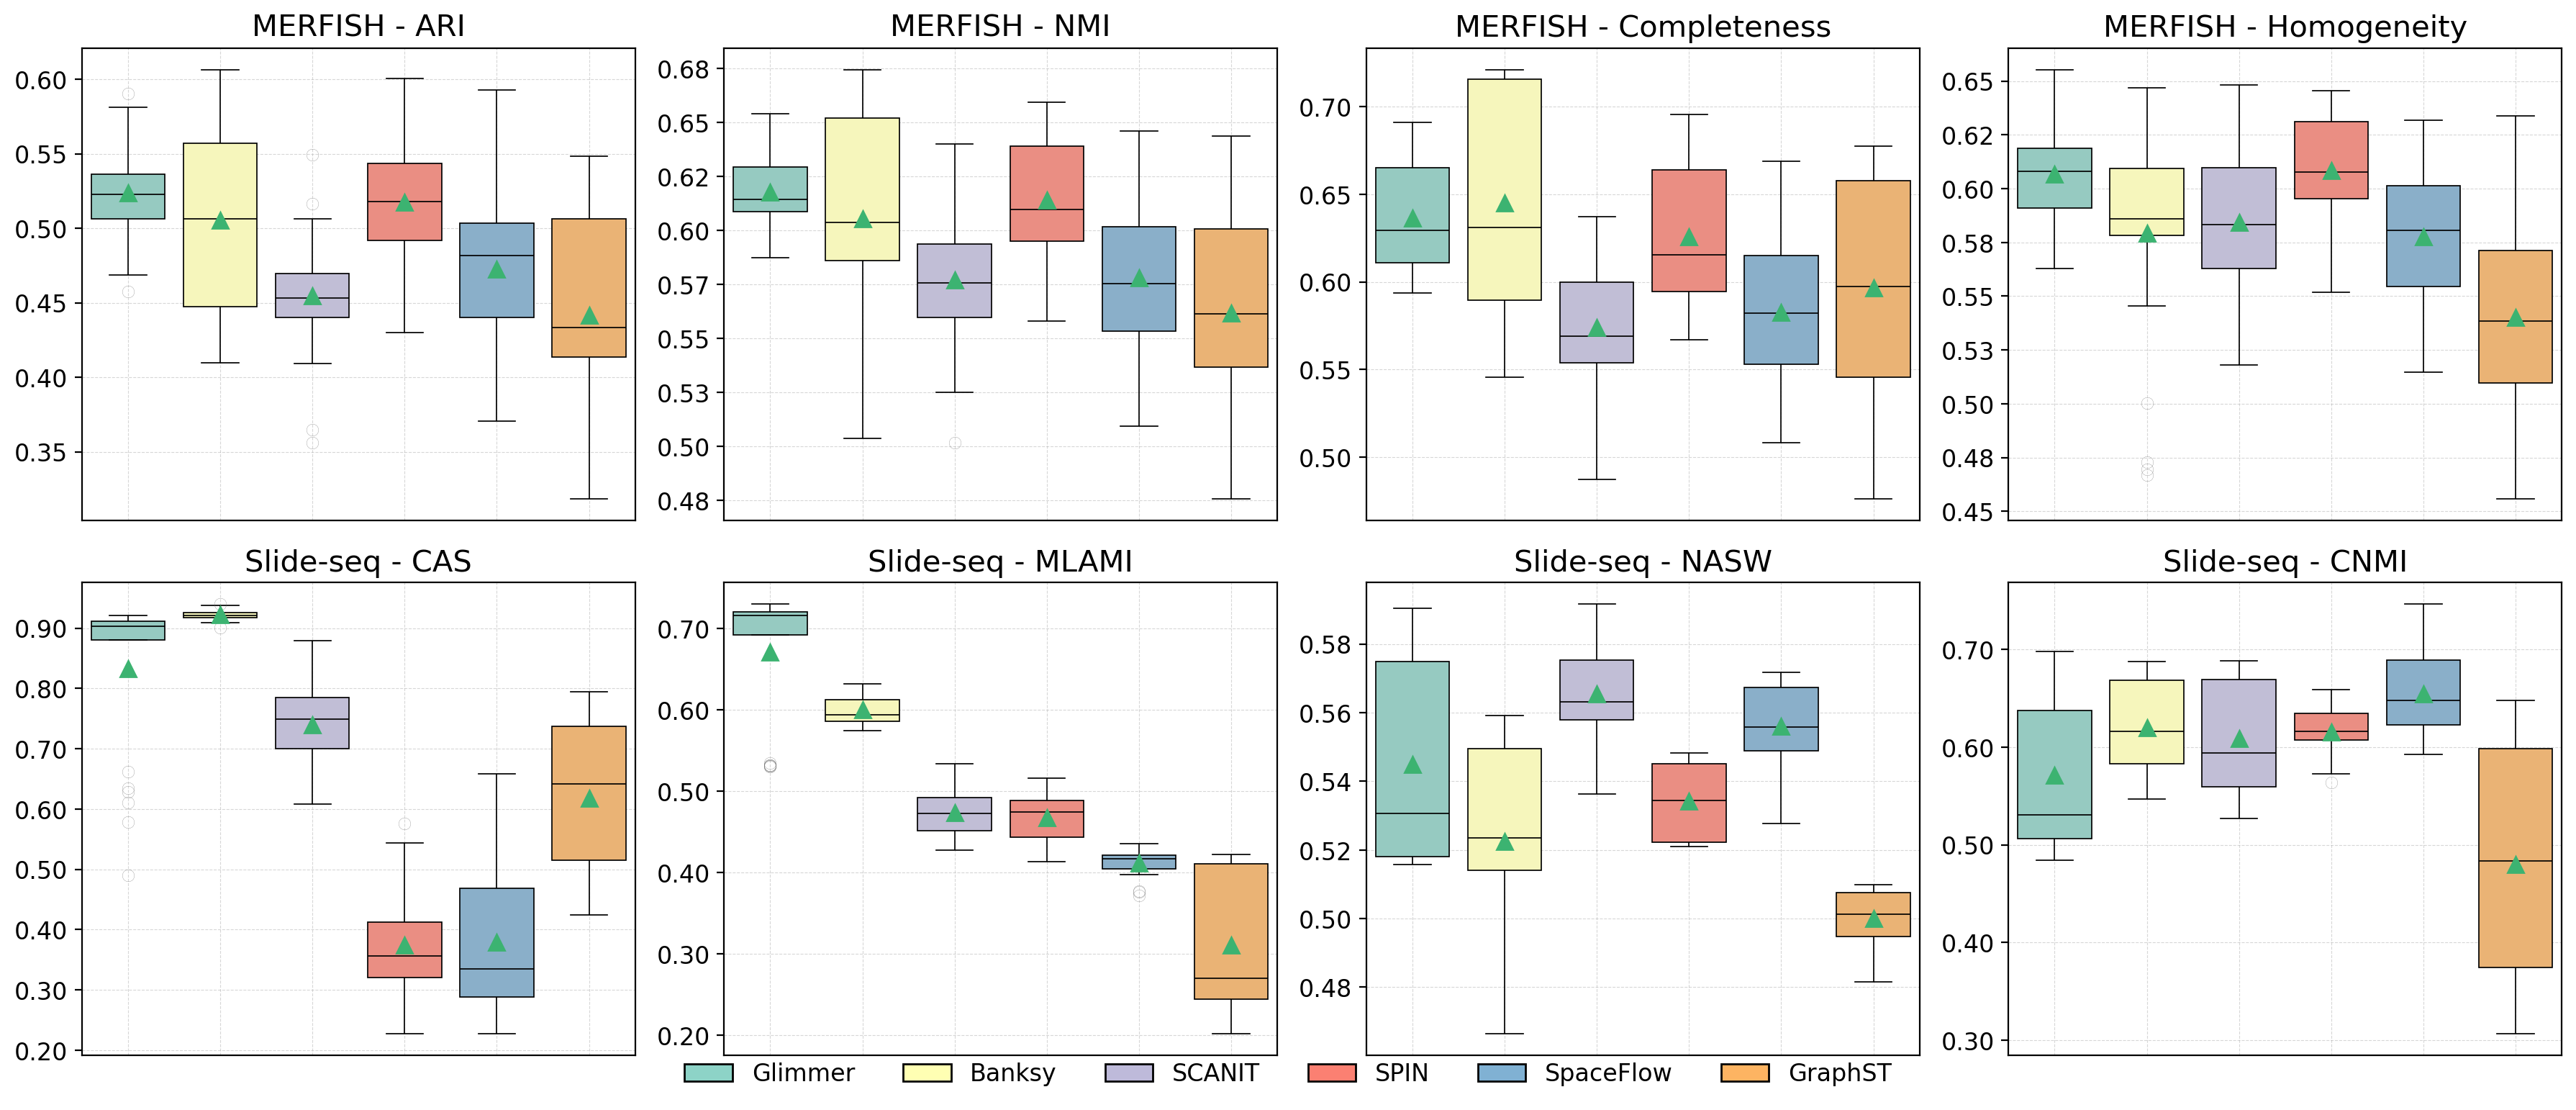

In [19]:
save_fig = True

merfish_metrics = ['ARI', 'NMI', 'Completeness', 'Homogeneity']
slideseq_metrics = ['CAS', 'MLAMI', 'NASW', 'CNMI']
method_order = ['Glimmer', 'Banksy', 'SCANIT', 'SPIN', 'SpaceFlow', 'GraphST']
model_colors = dict(zip(method_order, sns.color_palette("Set3", len(method_order))))

# MERFISH
all_df = pd.read_csv(f"{path}merfish/merfish_combined_scores.csv")
benchmark_df1 = all_df.rename(columns={
    'Model': 'method', 
    'Value': 'score', 
    'Metric': 'metric', 
    'data_num': 'sample'
})
benchmark_df1 = (
    benchmark_df1.groupby(['Embedding', 'sample', 'method', 'metric'])['score']
      .mean()
      .reset_index()
)
benchmark_df1['source'] = 'MERFISH'

# Slide-seq
benchmark_df2 = pd.concat(dfs, axis=0, ignore_index=True)
benchmark_df2 = benchmark_df2.melt(
    id_vars=['method', 'use_rep', 'sample'], 
    value_vars=metrics_list, 
    var_name='metric', 
    value_name='score'
)
benchmark_df2['source'] = 'Slide-seq'

# Combine
all_scores = pd.concat([benchmark_df1, benchmark_df2], axis=0, ignore_index=True)
all_scores = all_scores[all_scores['metric'].isin(merfish_metrics + slideseq_metrics)]
all_metrics = [(m, 'MERFISH') for m in merfish_metrics] + [(m, 'Slide-seq') for m in slideseq_metrics]

# Plot 
n_cols = 4
n_rows = (len(all_metrics) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4.5*n_cols, 3.8*n_rows))
axes = axes.flatten()
for idx, (metric, source) in enumerate(all_metrics):
    ax = axes[idx]
    data_subset = all_scores[(all_scores['metric'] == metric) & (all_scores['source'] == source)]
    sns.boxplot(data=data_subset, x="method", y="score", order=method_order,
                palette=model_colors,
                showmeans=True, 
                meanprops={"marker": "^", 
                           "markerfacecolor": "mediumseagreen", 
                           "markeredgecolor": "mediumseagreen", 
                           "markersize": 8},
                medianprops={"linewidth": 0.62, "color": "black"},
                boxprops={"linewidth": 0.62, "edgecolor": "black"},
                whiskerprops={"linewidth": 0.62, "color": "black"},
                capprops={"linewidth": 0.62, "color": "black"}, 
                flierprops={"marker": "o", "markersize": 6, "markeredgewidth": 0.1},
                ax=ax)
    ax.set_title(f"{source} - {metric}", fontsize=15)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.2f}"))
    ax.tick_params(axis='x', labelbottom=False, bottom=False)  
    ax.tick_params(axis='y', labelsize=12)
    ax.grid(axis='both', linestyle='--', linewidth=0.4, alpha=0.5)
for j in range(len(all_metrics), len(axes)):
    axes[j].axis("off")

legend_handles = [
    Patch(facecolor=model_colors[method], edgecolor='black', label=method)
    for method in method_order
]
fig.legend(
    handles=legend_handles,
    title="",
    loc="lower center",
    ncol=len(method_order),
    bbox_to_anchor=(0.5, -0.02),
    frameon=False,
    fontsize=12,
    title_fontsize=12
)
plt.tight_layout()
if save_fig:
    plt.savefig(fig_path + "figure3/fig3_combined_all_metrics_boxplot.svg", format="svg", bbox_inches="tight")
plt.show()  

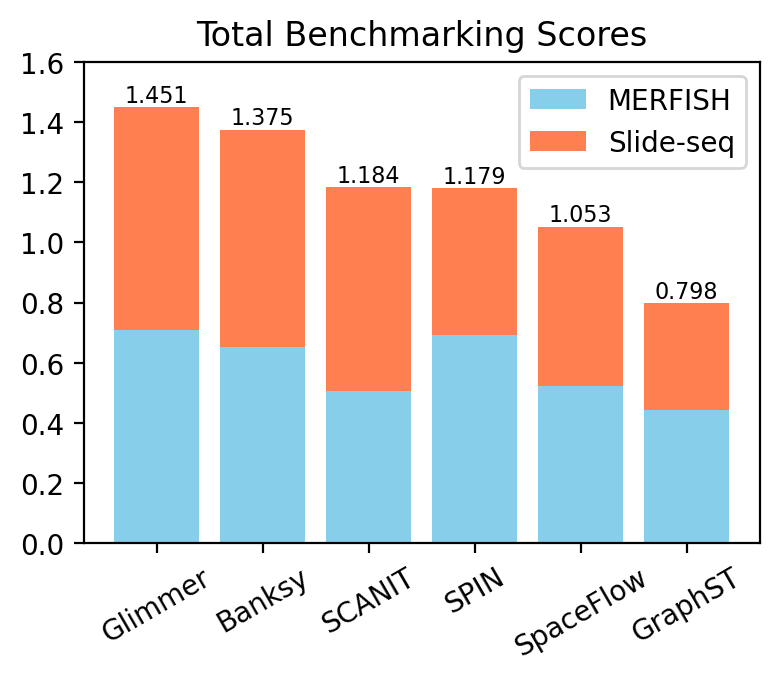

In [20]:
save_fig = True

all_scores['scaled_score'] = (
    all_scores
    .groupby(['source', 'metric'])['score']
    .transform(lambda x: minmax_scale(x.astype(float)))
)
score_summary = (
    all_scores
    .groupby(['method', 'source'])['scaled_score']
    .mean()
    .reset_index()
)
pivot_df = score_summary.pivot(index='method', columns='source', values='scaled_score').fillna(0)
pivot_df = pivot_df.loc[method_order]

# Plot
x = range(len(pivot_df))
fig, ax = plt.subplots(figsize=(4, 3.5))
bar1 = ax.bar(x, pivot_df['MERFISH'], color='skyblue', label='MERFISH')
bar2 = ax.bar(x, pivot_df['Slide-seq'], bottom=pivot_df['MERFISH'], color='coral', label='Slide-seq')
for i in x:
    total = pivot_df['MERFISH'].iloc[i] + pivot_df['Slide-seq'].iloc[i]
    ax.text(i, total, f"{total:.3f}", ha='center', va='bottom', fontsize=8)
ax.set_xticks(x)
ax.set_xticklabels(pivot_df.index, rotation=30)
ax.set_ylabel("")
ax.set_ylim(0, 1.6)
ax.set_title("Total Benchmarking Scores")
ax.legend(title="")
plt.tight_layout()
if save_fig:
    plt.savefig(fig_path + "figure3/fig3_s_combined_all_metrics_barplot.svg", format="svg", bbox_inches="tight")
plt.show()

### 4. Visualize the slide-seq regional results

In [21]:
seed_select = 1
data = '01'
rep_list = ['Our', 'SPIN', 'SCANIT', 'SpaceFlow', 'GraphST', 'Banksy']
tittle_list = ['Glimmer', 'SPIN', 'SCANIT', 'SpaceFlow', 'GraphST', 'Banksy']

save_adata_name = f"{path}/{data_type}/{data}/all_res_leiden.h5ad"
if os.path.exists(save_adata_name):
    print(f"Loading adata")
    adata = ad.read(save_adata_name)
else:
    load_file_name = f"{path}/{data_type}/{data}/all_res.h5ad"
    adata = ad.read(load_file_name)
    for m in rep_list:
        print(f"Running {m} for data {data}")
        use_rep = f"{m}_emb_seed{seed_select}"
        sc.pp.neighbors(adata, use_rep=use_rep, random_state=42)
        sc.tl.leiden(adata, resolution=0.6, random_state=42)
        adata.obs[f'{m}_leiden'] = adata.obs['leiden']
        sc.tl.umap(adata, random_state=42)
        adata.obsm[f'{m}_umap'] = adata.obsm['X_umap']
        adata.write(save_adata_name)

Loading adata


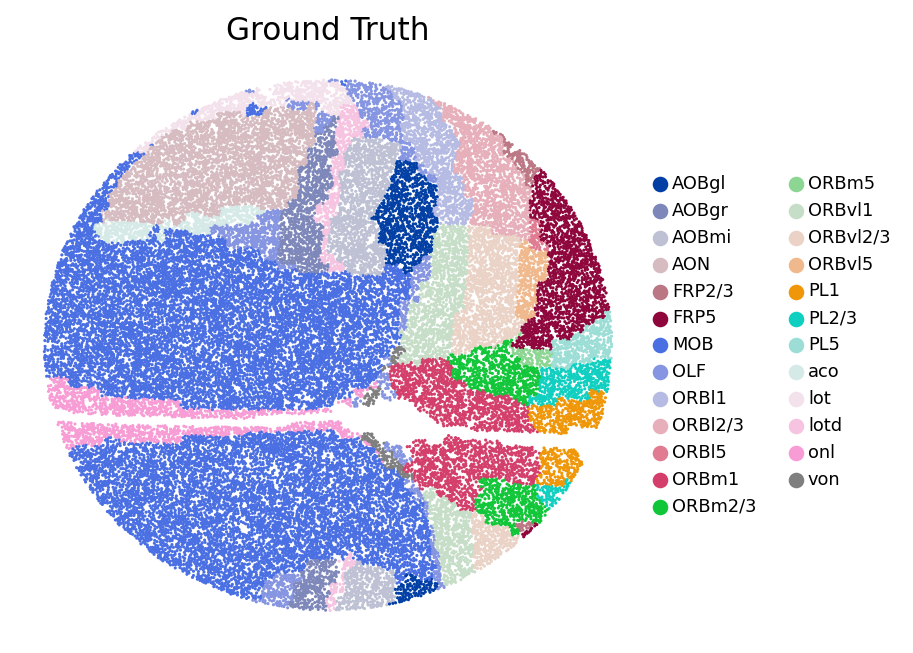

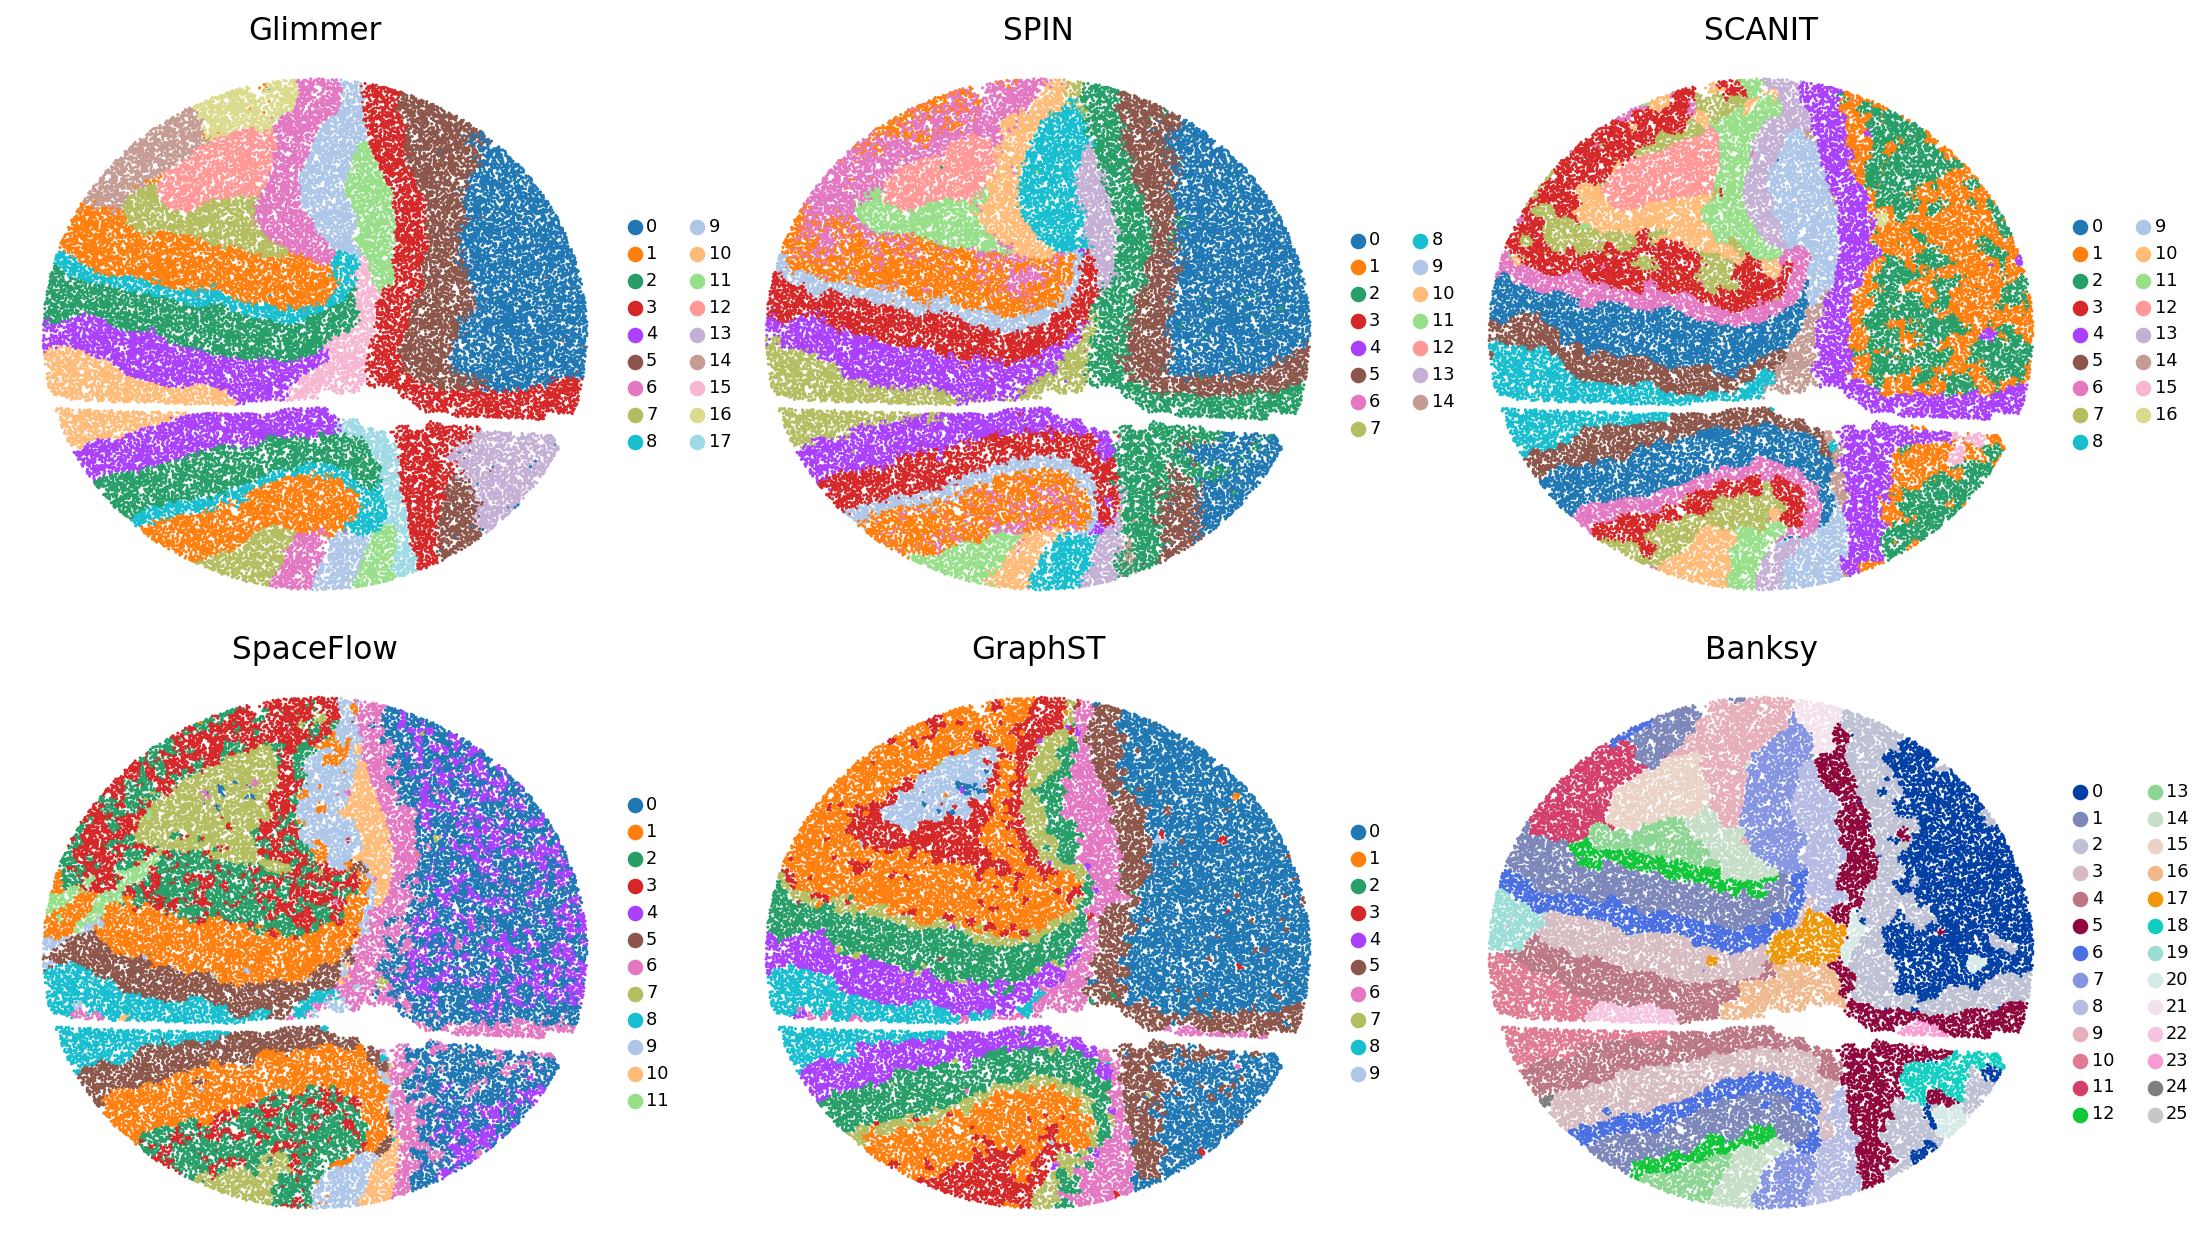

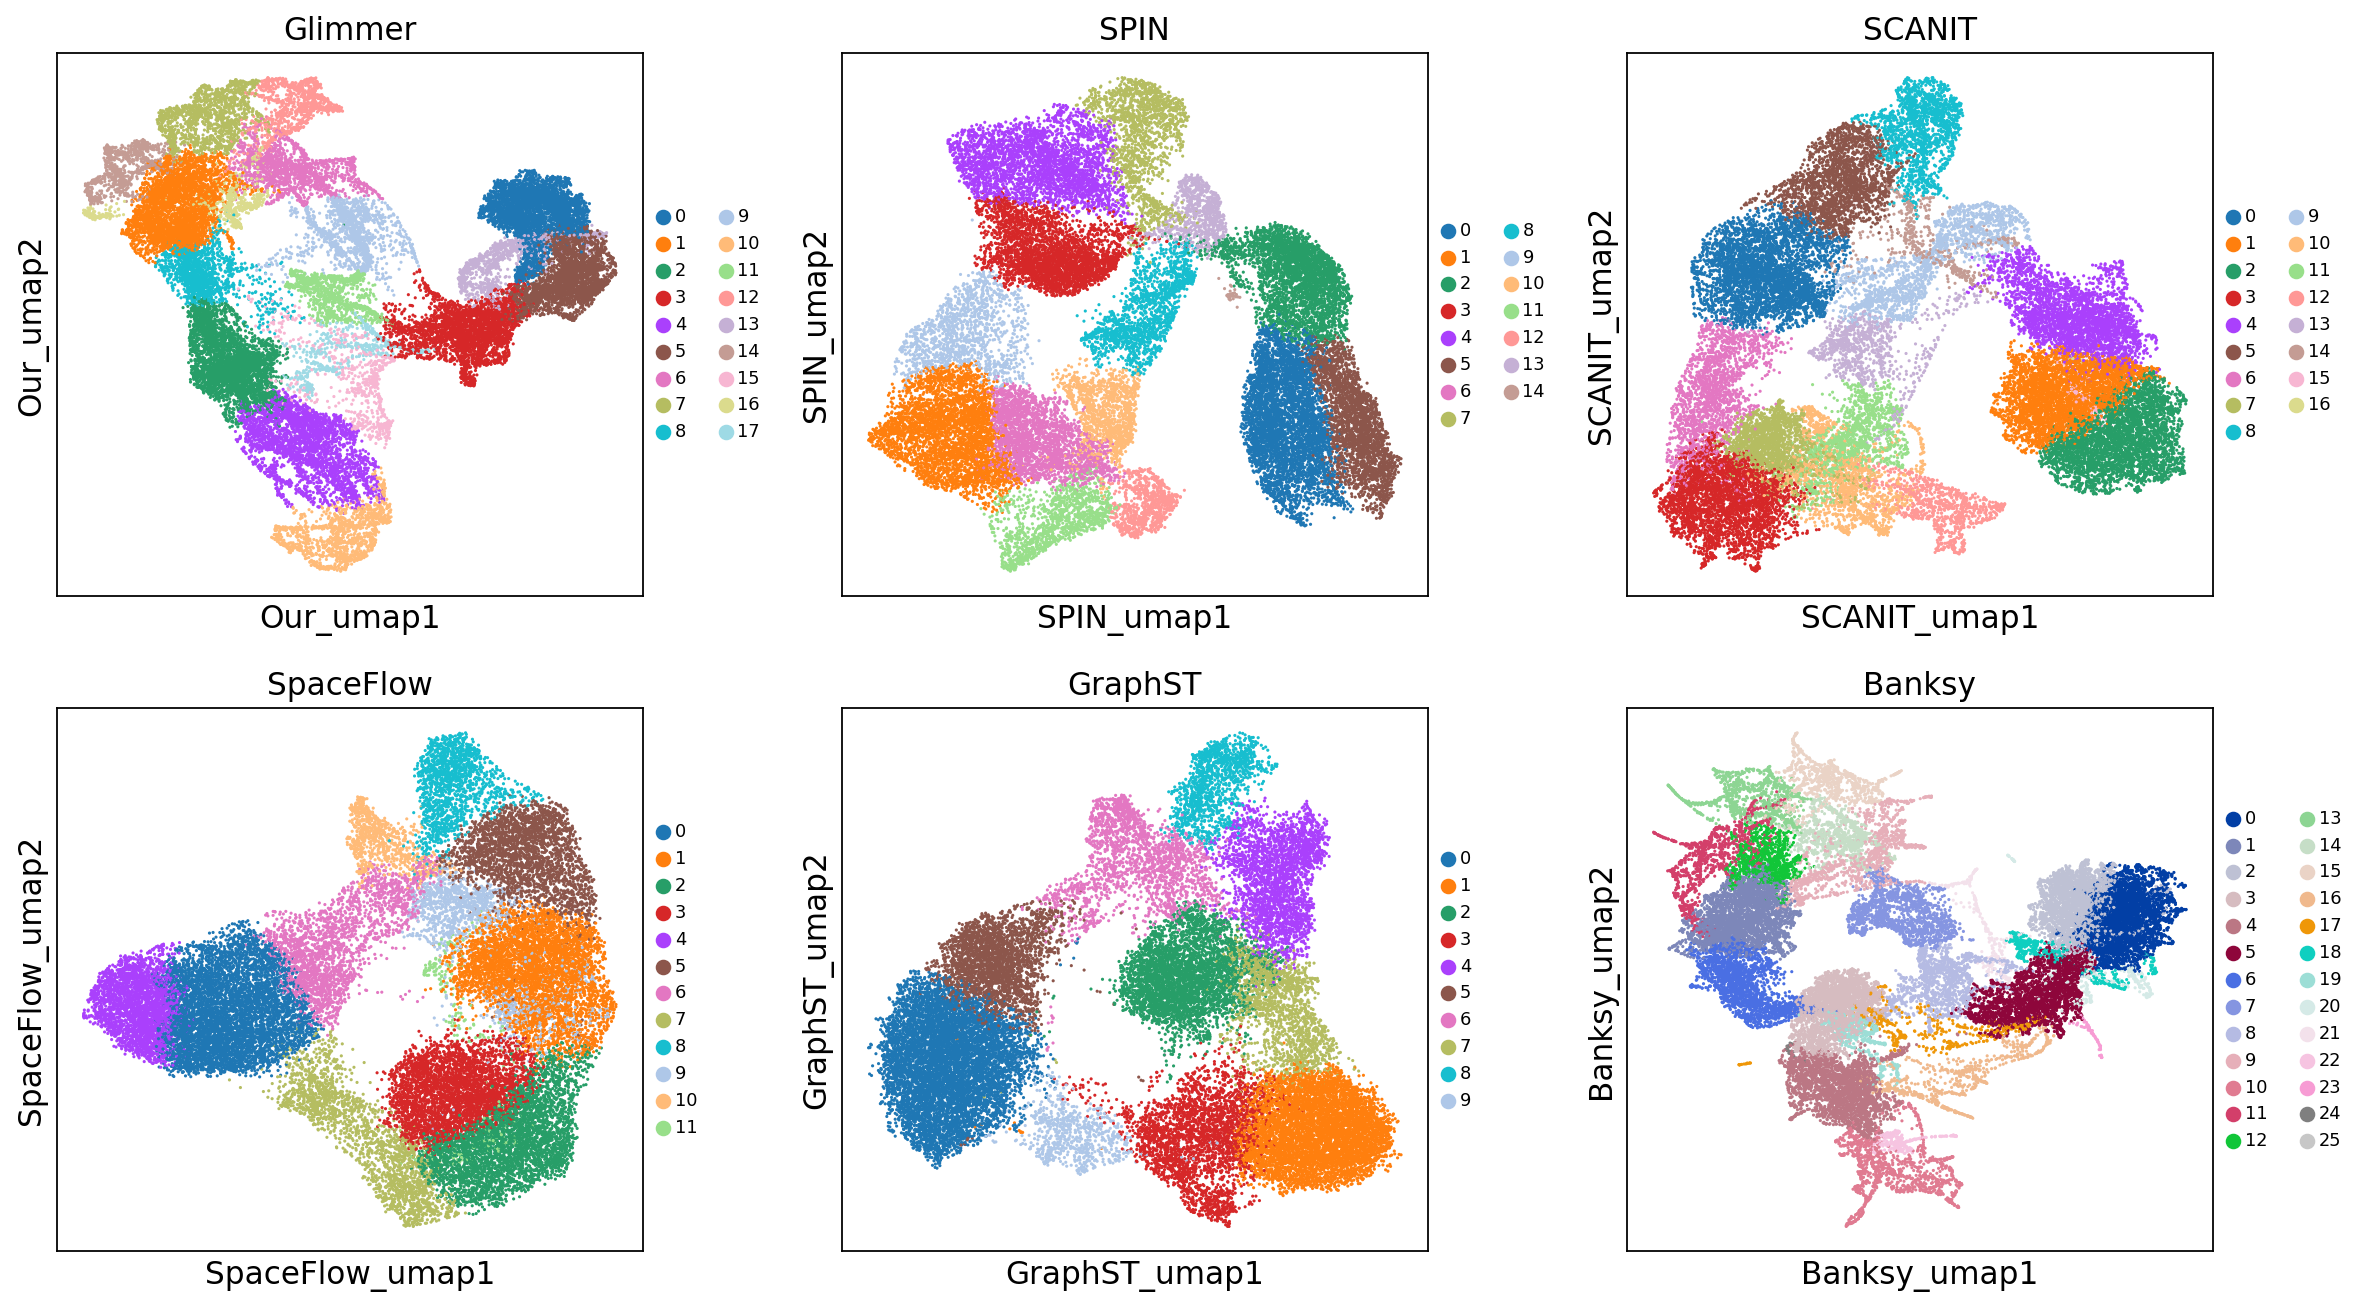

In [22]:
# spatial plot
save_fig = True
fig_base_path = fig_path + 'figure3/'
fig_names = [
    fig_base_path + 'fig3_m_slideseq_mouse_brain_ground_truth.svg',
    fig_base_path + 'fig3_m_slideseq_mouse_brain_spatial_leiden.svg',
    fig_base_path + 'fig3_s_slideseq_mouse_brain_umap_leiden.svg',
]

# Ground Truth (spatial)
pt_size = 8
sc.settings.set_figure_params(figsize=(5, 4.8))
fig1 = sc.pl.embedding(adata, basis='spatial', ncols=3, cmap='tab20', size=pt_size, legend_fontsize=8, 
                       color='CCF_acronym', title='Ground Truth', 
                       frameon=False, wspace=0.1, hspace=0.1, show=False, return_fig=True)
fig1.savefig(fig_names[0], format="svg", bbox_inches="tight")

# Leiden (spatial)
sc.settings.set_figure_params(figsize=(5, 4.5))
fig2 = sc.pl.embedding(adata, basis='spatial', ncols=3, cmap='tab20', size=pt_size, legend_fontsize=8, 
                       color=[f'{m}_leiden' for m in rep_list], 
                       title=tittle_list, frameon=False, wspace=0.1, hspace=0.1, show=False, return_fig=True)
fig2.savefig(fig_names[1], format="svg", bbox_inches="tight")

# Leiden (UMAP)
ncols = 3
nrows = (len(rep_list) // ncols) + (len(rep_list) % ncols > 0)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 4.2 * nrows))
axes = axes.flatten()
for i, m in enumerate(rep_list):
    if f'{m}_umap' in adata.obsm and f'{m}_leiden' in adata.obs:
        sc.pl.embedding(adata, basis=f'{m}_umap', cmap='tab20', size=pt_size, legend_fontsize=8, 
                        color=f'{m}_leiden', title=tittle_list[i], show=False, ax=axes[i])
    else:
        axes[i].axis("off")
for j in range(i + 1, len(axes)):
    axes[j].axis("off")
plt.tight_layout()
if save_fig:
    fig.savefig(fig_names[2], format="svg", bbox_inches="tight")
plt.show()

In [108]:
from bs4 import BeautifulSoup

def clean_svg_file(input_path, output_path=None):
    if output_path is None:
        output_path = input_path.replace(".svg", "_cleaned.svg")

    with open(input_path, "r", encoding="utf-8", errors="ignore") as f:
        content = f.read()
    try:
        soup = BeautifulSoup(content, "xml")
    except:
        print("xml fail, try html.parser")
        soup = BeautifulSoup(content, "html.parser")

    for tag_name in ["foreignObject", "style", "script", "defs", "metadata"]:
        for tag in soup.find_all(tag_name):
            tag.decompose()

    with open(output_path, "w", encoding="utf-8") as f:
        f.write(str(soup))
    return output_path

clean_svg_file(fig_names[1], fig_names[1])